# Ultimate Technologies Inc. Take-Home Challenge

[Part 1 ‑ Exploratory data analysis](#Part-1-‑-Exploratory-data-analysis)  
[Part 2 ‑ Experiment and metrics design](#Part-2-‑-Experiment-and-metrics-design)  
[Part 3 ‑ Predictive modeling](#Part-3-‑-Predictive-modeling)

## Part 1 ‑ Exploratory data analysis

The attached <i>logins.json</i> file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
# First, import the relevant modules
import requests
import json
import pandas as pd
import numpy as np
import os
from os import path

from matplotlib import pyplot as plt

In [2]:
#Database URL
url = 'ultimate_challenge/logins.json'
os.path.exists(url)
path.exists(url)
df = pd.read_json(url)


In [3]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
df.columns

Index(['login_time'], dtype='object')

In [6]:
df = df.resample('15T', on='login_time').count()

In [7]:
df.columns

Index(['login_time'], dtype='object')

In [8]:
df.columns = ['count']

In [9]:
df.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


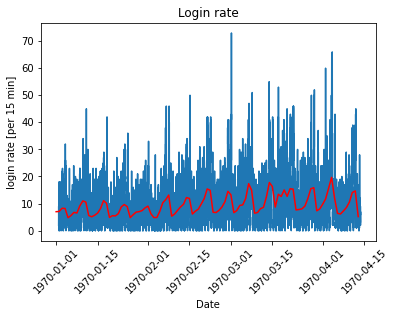

In [10]:
plt.plot(df['count'])
plt.plot(df.resample('D').mean(), c='red')
plt.ylabel("login rate [per 15 min]")
plt.xlabel("Date")
plt.title("Login rate")
plt.xticks(rotation=45)
plt.show()

The average login rate by day shows a weekly pattern.

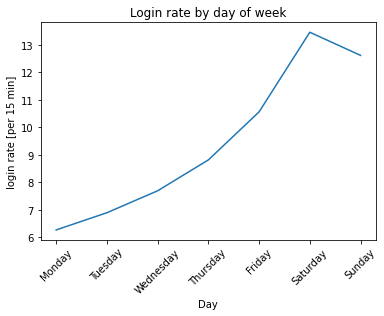

In [11]:
plt.plot(df["1970-01-02" : "1970-04-12"].groupby(df["1970-01-02" : "1970-04-12"].index.weekday).mean())
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=45)
plt.ylabel("login rate [per 15 min]")
plt.title("Login rate by day of week")
plt.xlabel("Day")
plt.show()


The login rate increases from Monday to Friday, and reaches a peak in the weekend.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Login rate by week')

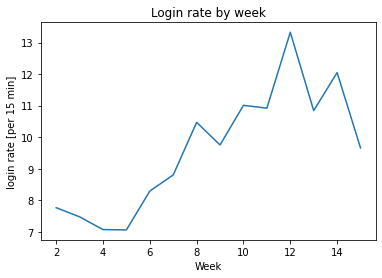

In [12]:
plt.plot(df.groupby(df.index.week).mean()[1:-1])
plt.ylabel('login rate [per 15 min]')
plt.xlabel('Week')
plt.title('Login rate by week')

The weekly login rate slowly increases during the year and reaches a peak in the 12th week.

Text(0.5, 1.0, 'Login rate by hour')

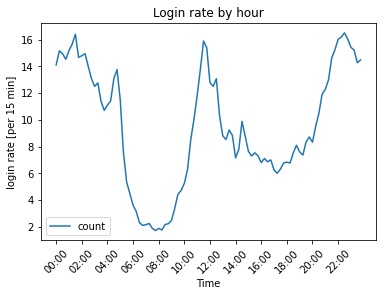

In [13]:
df.groupby(df.index.time).mean().plot(rot=45)
plt.xticks([7200 * h for h in range(12)])
plt.ylabel("login rate [per 15 min]")
plt.xlabel("Time")
plt.title("Login rate by hour")

On average, There are 2 peak hours in a day, 11:00 - 13:00 and 22:00 - 05:00.

Text(0.5, 1.0, 'Hourly login rate on different days of week')

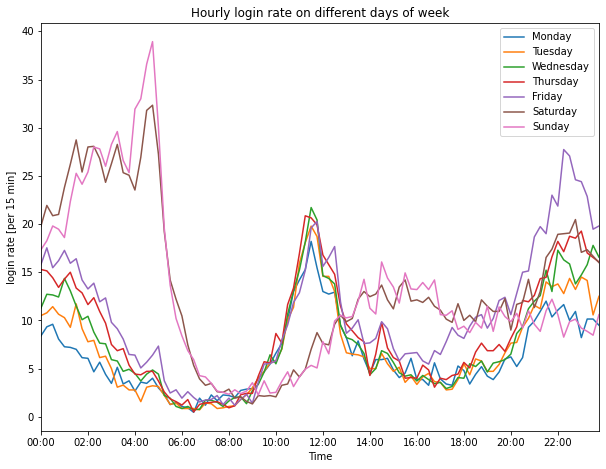

In [14]:
pd.plotting.register_matplotlib_converters()

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(10, 7.5))
for i in range(7):
    plt.plot(df.groupby([df.index.weekday, df.index.time]).mean().loc[i], label=day_of_week[i])
plt.ylabel("login rate [per 15 min]")
plt.xticks([7200 * h for h in range(12)])
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.xlim([0, 3600 * 23.75])
plt.title("Hourly login rate on different days of week")

The login rate has different hourly patterns on the weekends and weekdays. On the weekdays, the peak is usually around noon. On the weekends, most logins happen after midnight.

Text(0, 0.5, 'login rate [per 15 min]')

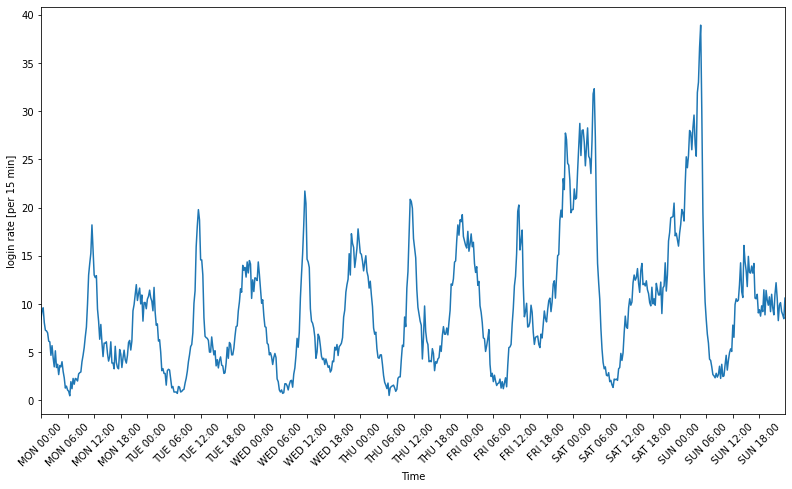

In [15]:
from itertools import product

logins_count_average_dayofweek_time = df.groupby([df.index.weekday, df.index.time]).mean()

timeIndex = [i * 15 for i in range(len(logins_count_average_dayofweek_time))]

plt.figure(figsize=(40/3, 7.5))
plt.plot(timeIndex, logins_count_average_dayofweek_time["count"])
day_of_week = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
xlabels = list(map(lambda x: x[0] + " " + x[1], product(day_of_week, ["00:00", "06:00", "12:00", "18:00"])))
plt.xlabel("Time")
plt.xticks([i * 6 * 60 for i in range(4 * 7)], xlabels, rotation=45)
plt.xlim([0, 60 * (24 * 6 + 23.75)])
plt.ylabel("login rate [per 15 min]")

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. <br>
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

The goal of this experiment is to increase the availability of drivers in both cities by encouraging them to cross the bridge. The crucial metrics that are related to driver availability is the wait time passengers experience after they request a ride and before a driver comes for pick-up. Higher driver availibity should significantly diminish the average wait time. <br>

A practical experiment should be conducted during two weeks when there are no holidays. For the whole second week, the drivers should be reimbursed for toll fees when they cross the bridge. The first week's data can be used as control.<br>

The trips passengers take should be binned in 15 or 30-min time windows, and the data scientist may use a two-independent-sample t-tset (the exact test to use whould be decided finally given the collected data and its distribution) to compare whether the average wait time in either city during corresponding time windows differes between the two weeks.<br>

One reasonable expectation of outcome of the experiment is that at certain time windows of a day in the week, the wait time is significantly shortenned, and at other time windows, it is not. This means that reimbursing toll fees ahould be able to increase driver availability in one city or another or in both. For instance, availability may improve in the peak hour of one city by the experiment, while at other times, it does not.<br>

Given the result, the company might be able to launch hour-specific toll-reimbursement strategies to improve driver availabilities when the hour is right. On the other hand, cost-effectiveness analysis is also needed to asses the benefit/profit that lauching a toll-reimbursement plan brings by comparing it to the increasing cost introduced by this plan.<br>

## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.<br>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.<br>
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.<br>
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? <br> Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).<br>
### Data description
 - **city**: city this user signed up in
 - **phone**: primary device for this user
 - **signup_date**: date of account registration; in the form ‘YYYY MM DD’
 - **last_trip_date**: the last time this user completed a trip; in the form ‘YYYY MM DD’
 - **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
 - **avg_rating_by_driver**: the rider’s average rating over all of their trips
 - **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
 - **surge_pct**: the percent of trips taken with surge multiplier > 1
 - **avg_surge**: The average surge multiplier over all of this user’s trips
 - **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up
 - **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days;<br>FALSE otherwise
 - **weekday_pct**: the percent of the user’s trips occurring during a weekday

In [16]:
url = 'ultimate_challenge/ultimate_data_challenge.json'
os.path.exists(url)
path.exists(url)
df = pd.read_json(url)

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [19]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['phone'].fillna('other', inplace=True)

There are missing data in the avg_rating_of_driver, avg_rating_by_driver and phone columns. The missing ratings are populated with the corresponding means, and the missing phones are named "other".

Text(0.5, 1.0, 'Post-Sign-Up Day -- Retention Rate')

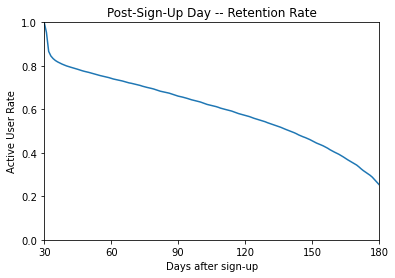

In [20]:
from datetime import timedelta

df.signup_date = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

active_days = df.last_trip_date - df.signup_date

active_rate = [(active_days >= timedelta(d - 30)).mean() for d in range(181)]
plt.plot(range(181), active_rate)
plt.xlim([30, 180])
plt.xticks([30 * d for d in range(1, 7)])
plt.xlabel("Days after sign-up")
plt.ylim([0, 1])
plt.ylabel("Active User Rate")
plt.title("Post-Sign-Up Day -- Retention Rate")

About 80% of users keep using the service after the first month. Half a year after sign-up, about 30% users are retained.

In [21]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date']).dt.date
df['last_trip_date'].head()


0    2014-06-17
1    2014-05-05
2    2014-01-07
3    2014-06-29
4    2014-03-15
Name: last_trip_date, dtype: object

In [22]:
from datetime import date

cutoff_date = date(year=2014, month=6, day=1)
active = df['last_trip_date'] > cutoff_date
active.name = "active"

Users whose last trip is after 06/01/2014 are identified as active/retained useres.

In [23]:
pd.crosstab(df.city, active, normalize="index")

active,False,True
city,,
Astapor,0.756744,0.243256
King's Landing,0.377394,0.622606
Winterfell,0.657996,0.342004


More users in King's Landing are active than those in Astapor and Winterfell.

In [24]:
pd.crosstab(df.phone, active, normalize="index")

active,False,True
phone,,
Android,0.804154,0.195846
iPhone,0.559366,0.440634
other,0.671717,0.328283


About 80% Android users are no longer active.

In [25]:
pd.crosstab(df.ultimate_black_user, active, normalize="index")

active,False,True
ultimate_black_user,,
False,0.712612,0.287388
True,0.503607,0.496393


Non-ultimate black users are less likely to stay active.

In [26]:
pd.pivot_table(pd.concat([df[["trips_in_first_30_days", "avg_rating_of_driver", "avg_surge", "surge_pct", "weekday_pct", "avg_dist", "avg_rating_by_driver"]], active], axis=1), index="active")

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
active,,,,,,,
False,6.188478,4.786830,4.605889,1.075367,8.688548,1.659167,60.181597
True,5.118977,4.763149,4.594066,1.073720,9.128165,3.349590,62.214604


Active users tend to travel shorter distance than inactive users. They travel slightly more frequentyly on weekdays than inactive users. They also take slightly more surge trips. Active users usually take more trips than inactive users within the first 30 days of their sign-up.

The difference between the ratings either received or given by active an inactive users is very minimal. There is also no significant difference in average surge rate. Thus, these columns are ignored in the predictive model.

Text(0.5, 1.0, 'Histogram -- Average Distance')

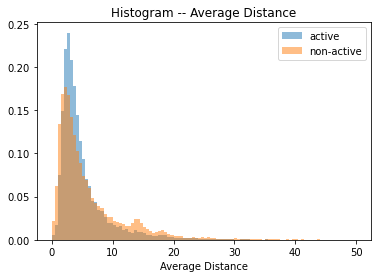

In [27]:
plt.hist(df.avg_dist[active], bins=np.linspace(0, 50, 101), density=True, alpha=0.5, label="active")
plt.hist(df.avg_dist[~active], bins=np.linspace(0, 50, 101), density=True, alpha=0.5, label="non-active")
plt.legend()
plt.xlabel("Average Distance")
plt.title("Histogram -- Average Distance")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Histogram -- log-10 of Average Distance')

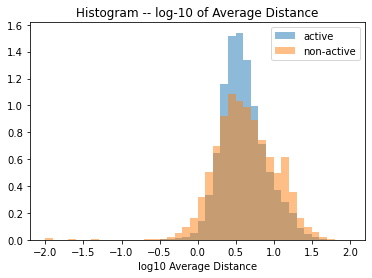

In [28]:
log_avg_dist = np.log10(df.avg_dist)
plt.hist(log_avg_dist[active], bins=np.linspace(-2, 2, 41), density=True, alpha=0.5, label="active")
plt.hist(log_avg_dist[~active], bins=np.linspace(-2, 2, 41), density=True, alpha=0.5, label="non-active")
plt.legend()
plt.xlabel("log10 Average Distance")
plt.title("Histogram -- log-10 of Average Distance")

```avg_dist``` is log normal. Thus, it should be transformed to log scale.

Text(0.5, 1.0, 'Histogram of number of trips taken within first 30 days of sign-up')

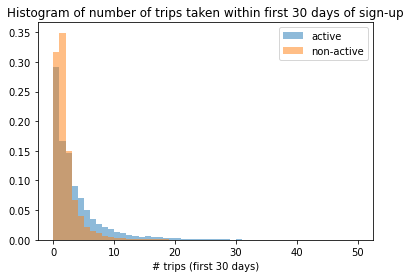

In [29]:
plt.hist(df.trips_in_first_30_days[active], bins=np.linspace(0, 50, 51), density=True, alpha=0.5, label="active")
plt.hist(df.trips_in_first_30_days[~active], bins=np.linspace(0, 50, 51), density=True, alpha=0.5, label="non-active")
plt.legend()
plt.xlabel("# trips (first 30 days)")
plt.title("Histogram of number of trips taken within first 30 days of sign-up")

```trips_in_first_30_days``` is Poisson distributed. However, as the variance in the data is not extreme, stablization transforms may not be necessary.

In [30]:
users_processed = df[["trips_in_first_30_days", "surge_pct", "weekday_pct", "avg_dist"]]
users_processed.surge_pct = users_processed.surge_pct / 100
users_processed.weekday_pct = users_processed.weekday_pct / 100
users_processed.avg_dist[users_processed.avg_dist == 0] = 0.01
users_processed.avg_dist =np.log10(users_processed.avg_dist)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

The ```avg_dist``` is converted to log-10 scale.

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder_city = LabelEncoder()
integer_city = label_encoder_city.fit_transform(df.city)
onehot_encoder_city = OneHotEncoder(sparse=False)
onehot_city = onehot_encoder_city.fit_transform(integer_city.reshape(-1, 1))
city = pd.DataFrame(onehot_city[:, [0, 1]], columns=["city_0", "city_1"], index = users_processed.index)

In [32]:
label_encoder_phone = LabelEncoder()
integer_phone = label_encoder_city.fit_transform(df.phone)
onehot_encoder_phone = OneHotEncoder(sparse=False)
onehot_phone = onehot_encoder_phone.fit_transform(integer_phone.reshape(-1, 1))
phone = pd.DataFrame(onehot_phone[:, [0, 1]], columns=["phone_0", "phone_1"], index = users_processed.index)

In [33]:
label_encoder_black = LabelEncoder()
integer_black = label_encoder_black.fit_transform(df.ultimate_black_user)
ultimate_black_user = pd.DataFrame(integer_black, columns = ["ultimate_black_user"], index = users_processed.index)

The ```city```, ```phone``` and ```ultimate_black_user``` columns are converted to one hot encoding.

In [34]:
users_processed = pd.concat([users_processed, city, phone, ultimate_black_user], axis=1)

In [35]:
users_processed.head()

,trips_in_first_30_days,surge_pct,weekday_pct,avg_dist,city_0,city_1,phone_0,phone_1,ultimate_black_user
0,4,0.154,0.462,0.564666,0.0,1.0,0.0,1.0,1
1,0,0.000,0.500,0.916980,1.0,0.0,1.0,0.0,0
2,3,0.000,1.000,-0.113509,1.0,0.0,0.0,1.0,0
3,9,0.200,0.800,0.372912,0.0,1.0,0.0,1.0,1
4,14,0.118,0.824,0.495544,0.0,0.0,1.0,0.0,0


The pre-processed data ready for the model ```contain trip_in_first_30_days```, ```surge_pct```, ```weekday_pct```, ```avg_dist```, ```city```, ```phone``` and ```ultimate_black_user```.

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(users_processed, active, test_size=0.25)

train_avg_dist_maen = X_train.avg_dist.mean()
train_avg_dist_sd = X_train.avg_dist.std()
X_train.avg_dist = (X_train.avg_dist - train_avg_dist_maen) / train_avg_dist_sd
X_test.avg_dist = (X_test.avg_dist - train_avg_dist_maen) / train_avg_dist_sd

train_trips_30_mean = X_train.trips_in_first_30_days.mean()
train_trips_30_sd = X_train.trips_in_first_30_days.std()
X_train.trips_in_first_30_days = (X_train.trips_in_first_30_days - train_trips_30_mean) / train_trips_30_sd
X_test.trips_in_first_30_days = (X_test.trips_in_first_30_days - train_trips_30_mean) / train_trips_30_sd

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The data are split to two parts, 25% as test set and 75% as training set. `trips_in_first_30_days` and `log-10` of `avg_dist` are z-scored using parameters estimated from the training set.

Because the target variable is binomial ("active" v.s. "non-active") and the number of independent variables is limited, logistic regression is chosen.

Text(0.5, 1.0, 'Trips in first 30 days -- average distance (training set)')

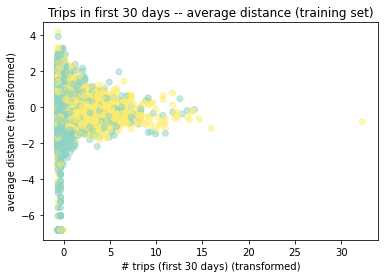

In [37]:
plt.scatter(X_train.trips_in_first_30_days, X_train.avg_dist, c=y_train, alpha=0.5, cmap="Set3")
plt.xlabel("# trips (first 30 days) (transformed)")
plt.ylabel("average distance (transformed)")
plt.title("Trips in first 30 days -- average distance (training set)")

One of the concerns regarding using a logistic regression model is that active/non-active users' data points cannot be separated linearly. The above scatter plot of `trips_in_first_30_days` and `avg_dist` shows although distributions of the two populations have significant overlaps, it is possible to linearly separate the data points to a large extent. However, if the data were not linearly separable, a decision tree might be a better model.

Text(0, 0.5, 'accuracy')

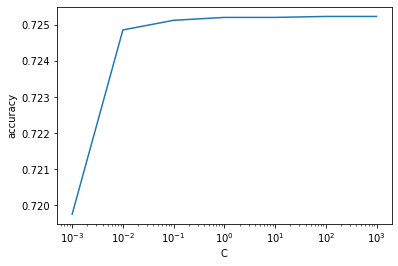

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty="l2", solver="liblinear")
C_grid = {"C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_searcher = GridSearchCV(lr, C_grid, cv=20)
grid_searcher.fit(X_train, y_train)

scores = grid_searcher.cv_results_["mean_test_score"]
Cs = grid_searcher.cv_results_["param_C"].data
plt.plot(Cs, scores)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")

The regression uses L2 regularization. Cross-validation within the training set is used to determine the strength of regularization.

accuracy = 0.71888


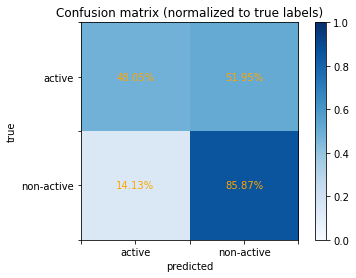

In [39]:
from sklearn.metrics import confusion_matrix
import itertools

best_C = 0.1
classifier = LogisticRegression(penalty="l2", C=best_C, solver="liblinear").fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = cm / np.reshape(np.repeat(np.sum(cm, axis=1), 2), [2, 2])

plt.imshow(cm, cmap="Blues")
for i in range(2) :
    for j in range(2):
        text = plt.gca().text(j, i, str(round(cm[i, j] * 10000) / 100) + str("%"),
                       ha="center", va="center", color="orange")
plt.colorbar()
plt.clim(0, 1)
plt.xlabel("predicted")
plt.xticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.ylabel("true")
plt.yticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.title("Confusion matrix (normalized to true labels)")

print("accuracy = " + str(sum(y_pred == y_test) / len(y_test)))

The accuracy of the classifier is 72%. In true active users, it almost classifies by chance. It does a better job finding true non-active users. Out of all non-active users, the classifier is able to identify 86% of all non-active users.

accuracy = 0.71888


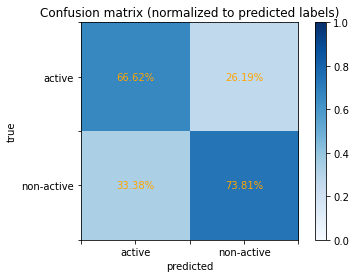

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = cm / np.transpose(np.reshape(np.repeat(np.sum(cm, axis=0), 2), [2, 2]))

plt.imshow(cm, cmap="Blues")
for i in range(2) :
    for j in range(2):
        text = plt.gca().text(j, i, str(round(cm[i, j] * 10000) / 100) + str("%"),
                       ha="center", va="center", color="orange")
plt.colorbar()
plt.clim(0, 1)
plt.xlabel("predicted")
plt.xticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.ylabel("true")
plt.yticks(ticks=[-0.5, 0, 0.5, 1, 1.5], labels=["", "active", "", "non-active", ""])
plt.title("Confusion matrix (normalized to predicted labels)")

print("accuracy = " + str(sum(y_pred == y_test) / len(y_test)))

On average, the classifer performs slightly better in identifying non-active users than confirming active users. Thus, Ultimate could use the model to target non-active users, and launch marketing strategies and promotions to retain them.

precision-recall AUC = 0.65021347105577


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


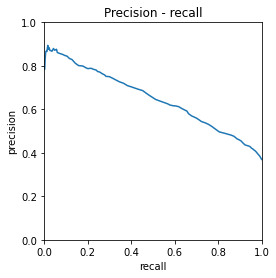

In [41]:
from sklearn.metrics import auc

y_prob = classifier.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101)
true_pos = thresholds * 0
false_pos = thresholds * 0
false_neg = thresholds * 0
true_neg = thresholds * 0
for i, t in enumerate(thresholds):
    y_pred = y_prob > t
    true_pos[i] = sum(y_pred & y_test)
    true_neg[i] = sum((y_pred == False) & (y_test == False))
    false_pos[i] = sum(y_pred & (y_test == False))
    false_neg[i] = sum((y_pred == False) & y_test)
    
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
sensitivity = recall
specificity = true_neg / (true_neg + false_pos)

plt.plot(recall, precision)
plt.xlim([0, 1])
plt.xlabel("recall")
plt.ylim([0, 1])
plt.ylabel("precision")
plt.gca().set_aspect("equal")
plt.title("Precision - recall")

precision[-1] = 0
auc_value = auc(recall, precision)
print("precision-recall AUC = " + str(auc_value))

The area under precision-recall curve is 0.66.

Text(0.5, 1.0, 'Sensitivity - specificity')

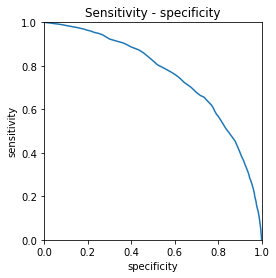

In [42]:
plt.plot(specificity, sensitivity)
plt.xlim([0, 1])
plt.xlabel("specificity")
plt.ylim([0, 1])
plt.ylabel("sensitivity")
plt.gca().set_aspect("equal")
plt.title("Sensitivity - specificity")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


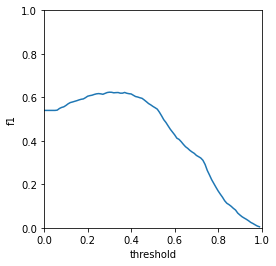

In [43]:
f1 = 2 * precision * recall / (precision + recall)

plt.plot(thresholds, f1)
plt.xlim([0, 1])
plt.xlabel("threshold")
plt.ylim([0, 1])
plt.ylabel("f1")
plt.gca().set_aspect("equal")

Overall, a logstic regression model is able to capture data pattern that predicts user retainablility, especially identifying users who Ultimate might be losing. The company can use similar approaches to find users going inactive, and launch targeted promotion campain to keep them.